In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import preprocessing

from google.colab import drive
drive.mount('/content/drive')
path_file = '/content/drive/MyDrive/Copia de dataset_Caso_1.csv'
caso_1= pd.read_csv(path_file, encoding="ISO-8859-1")
caso_1.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,x1,x2,x3,x4,x5,x6,x7,x8,target
0,50.1341,-326.0000,SAT,MZBER,0,0,6,-6.5,0
1,50.1341,-326.0000,SAT,MZBER,0,0,6,-4.5,0
2,124.3276,-275.1935,LCV,MZBER,0,0,3,-2.5,0
3,50.1341,-326.0000,SAT,MZBER,0,0,3,-4.5,0
4,85.3905,-298.8632,XJB,MZBER,0,0,5,-4.5,0


In [29]:
# Configuración para mostrar todas las filas y columnas sin truncar
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Se define una funcion para visualizar un resumen estadístico de la data
def eda(bd):
  print("Este es el reporte de Análisis Exploratorio de Datos de su DataFrame:")
  print(" ")
  print("El dataset contiene", bd.shape[1], " features y ", bd.shape[0], " instancias")
  print("")
  print("Las variables del dataset son:")
  print(" ")
  print(bd.columns.tolist())
  print(" ")
  print("Los datos nulos por feature son:")
  print(" ")
  print( bd.isna().sum())
  print(" ")
  print("Las instancias duplicadas son: ")
  print(bd.duplicated().sum())
  print(" ")
  print("Los datos únicos por feature son:")
  print(" ")
  print(bd.nunique())
  print(" ")
  return bd.describe().transpose()

In [30]:
eda(caso_1)

Este es el reporte de Análisis Exploratorio de Datos de su DataFrame:
 
El dataset contiene 9  features y  2000  instancias

Las variables del dataset son:
 
['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'target']
 
Los datos nulos por feature son:
 
x1        0
x2        0
x3        0
x4        0
x5        0
x6        0
x7        0
x8        0
target    0
dtype: int64
 
Las instancias duplicadas son: 
157
 
Los datos únicos por feature son:
 
x1        1183
x2        1149
x3           4
x4           4
x5           2
x6           2
x7           5
x8           7
target       2
dtype: int64
 


,count,mean,std,min,25%,50%,75%,max
x1,2000.0,101.074885,22.670474,50.1341,89.501675,105.2361,116.023175,150.1341
x2,2000.0,-298.282145,16.596490,-326.0000,-308.930400,-297.8256,-288.169025,-226.0000
x5,2000.0,0.012500,0.111130,0.0000,0.000000,0.0000,0.000000,1.0000
x6,2000.0,0.027000,0.162124,0.0000,0.000000,0.0000,0.000000,1.0000
x7,2000.0,3.440500,0.972591,3.0000,3.000000,3.0000,3.000000,8.0000
x8,2000.0,-5.343500,1.570108,-7.5000,-6.500000,-5.5000,-4.500000,-1.5000
target,2000.0,0.011000,0.104329,0.0000,0.000000,0.0000,0.000000,1.0000


In [31]:
# Borramos duplicados
caso_1 = caso_1.drop_duplicates()

In [32]:
# Realizar el one-hot encoding de las columnas 'x3' y 'x4'
caso_1 = pd.get_dummies(caso_1, columns=['x3', 'x4'])

# Mostrar las primeras filas del DataFrame codificado
caso_1.head()

,x1,x2,x5,x6,x7,x8,target,x3_LCV,x3_QKP,x3_SAT,x3_XJB,x4_MZBER,x4_PQKE,x4_YEQA,x4_ZUQF
0,50.1341,-326.0000,0,0,6,-6.5,0,False,False,True,False,True,False,False,False
1,50.1341,-326.0000,0,0,6,-4.5,0,False,False,True,False,True,False,False,False
2,124.3276,-275.1935,0,0,3,-2.5,0,True,False,False,False,True,False,False,False
3,50.1341,-326.0000,0,0,3,-4.5,0,False,False,True,False,True,False,False,False
4,85.3905,-298.8632,0,0,5,-4.5,0,False,False,False,True,True,False,False,False


In [34]:
# Importamos algunas librerías extras para el entrenamiento
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
    auc,
)
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [35]:
# Balance de clases
caso_1['target'].value_counts()

,count
target,
0,1821
1,22


In [36]:
# Split features and target variable
X = caso_1.drop(columns=['target'])
y = caso_1['target']

In [37]:
# Optimizamos hiperparámetros para obtener los hiperparámetros del modelo (por cada vez que este código se corre se otienen distintos, los utilizados fueron los arrojados en la primera ejecución,
# esta ejecución es para ilustrar cómo se ve)

import optuna # Librería Optuna

# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'objective': 'binary:logistic',
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'gamma': trial.suggest_uniform('gamma', 0, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'scale_pos_weight': trial.suggest_loguniform('scale_pos_weight', 1e-2, 10),
        'nthread': 4,
        'seed': 42
    }

    # Initialize StratifiedKFold with 5 folds
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    auc_scores_valid = []

    # Perform k-fold cross-validation
    for train_index, val_index in kf.split(X, y):
        X_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        # Initialize XGBoost classifier
        clf = XGBClassifier(
            n_estimators=1000,  # Train for a large number of trees initially
            **params
        )

        # Manual Early Stopping
        best_score = 0
        best_iteration = 0
        no_improvement_count = 0

        for i in range(1, 1001):  # Train up to 1000 trees
            clf.set_params(n_estimators=i)
            clf.fit(X_fold, y_fold, verbose=0)

            # Predict probabilities on validation set
            y_val_proba = clf.predict_proba(X_val_fold)[:, 1]
            score = roc_auc_score(y_val_fold, y_val_proba)

            # Check for improvement
            if score > best_score:
                best_score = score
                best_iteration = i
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            if no_improvement_count >= 10:
                break

        # Refit the model with the best iteration
        clf.set_params(n_estimators=best_iteration)
        clf.fit(X_fold, y_fold, verbose=0)

        # Predict probabilities on the validation fold
        y_val_proba = clf.predict_proba(X_val_fold)[:, 1]

        # Calculate AUC score for the current fold
        auc_score_valid = roc_auc_score(y_val_fold, y_val_proba)
        auc_scores_valid.append(auc_score_valid)

    # Return the average AUC score to optimize
    return np.mean(auc_scores_valid)

# Create the Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print(f'Best Parameters: {study.best_params}')
print(f'Best AUC Score: {study.best_value}')

[I 2024-08-24 00:38:01,085] A new study created in memory with name: no-name-a03175b8-142a-4c16-a332-b42e8e66ad37
<ipython-input-37-1abfe93a7761>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
<ipython-input-37-1abfe93a7761>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-37-1abfe93a7761>:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'gamma': trial.suggest_uniform('gamma', 0, 1.0),
<ipython-inpu

Best Parameters: {'learning_rate': 0.0016523625834336101, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.735257592660935, 'gamma': 0.32246236077822354, 'colsample_bytree': 0.9573747254255919, 'scale_pos_weight': 9.975413916285097}
Best AUC Score: 0.8756303627878971


In [38]:
# Tratamiento de Outliers

# Crear DataFrame para almacenar cuartiles
cuartiles_num = pd.DataFrame(
    columns=[
        "Variable",
        "Q1",
        "Q2",
        "Q3",
        "min",
        "max",
        "IQR",
        "cota_inferior",
        "cota_superior",
        "outliers_superiores",
        "outliers_inferiores",
        "std_dev",
    ]
)

# Lista de variables numéricas sin 'periodo' ni 'churn'
numericas = [
    col
    for col in caso_1.columns
    if col
    not in [
        "target",
        "x3_LCV",
        "x3_QKP",
        "x3_SAT",
        "x3_XJB",
        "x4_MZBER",
        "x4_PQKE",
        "x4_YEQA",
        "x4_ZUQF",
        ]
]

# Lista para almacenar los DataFrames intermedios
dataframes_to_concat = []

# Iterar sobre cada variable numérica
for variable in numericas:
    # Obtener los datos de la variable
    data = caso_1[variable]

    # Calcular cuartiles y otros estadísticos
    Q1 = data.quantile(0.25)
    Q2 = data.median()
    Q3 = data.quantile(0.75)
    min_val = data.min()
    max_val = data.max()
    IQR = Q3 - Q1
    cota_inferior = Q1 - 1.5 * IQR
    cota_superior = Q3 + 1.5 * IQR
    outliers_superiores = max_val > cota_superior
    outliers_inferiores = min_val < cota_inferior
    std_dev = data.std()  # Calcular desviación estándar

    # Crear un DataFrame temporal para cada variable
    temp_df = pd.DataFrame(
        {
            "Variable": [variable],
            "Q1": [Q1],
            "Q2": [Q2],
            "Q3": [Q3],
            "min": [min_val],
            "max": [max_val],
            "IQR": [IQR],
            "cota_inferior": [cota_inferior],
            "cota_superior": [cota_superior],
            "outliers_superiores": [outliers_superiores],
            "outliers_inferiores": [outliers_inferiores],
            "std_dev": [std_dev],
        }
    )

    # Agregar el DataFrame temporal a la lista
    dataframes_to_concat.append(temp_df)

# Concatenar todos los DataFrames temporales en uno
cuartiles_num = pd.concat(dataframes_to_concat, ignore_index=True)

cuartiles_num


,Variable,Q1,Q2,Q3,min,max,IQR,cota_inferior,cota_superior,outliers_superiores,outliers_inferiores,std_dev
0,x1,92.9912,106.4304,116.8008,50.1341,150.1341,23.8096,57.2768,152.5152,False,True,18.610906
1,x2,-306.3425,-296.4918,-287.0323,-326.0000,-226.0000,19.3102,-335.3078,-258.0670,True,False,15.264666
2,x5,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,True,False,0.115707
3,x6,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,True,False,0.168692
4,x7,3.0000,3.0000,3.0000,3.0000,8.0000,0.0000,3.0000,3.0000,True,False,0.902015
5,x8,-6.5000,-5.5000,-4.5000,-7.5000,-1.5000,2.0000,-9.5000,-1.5000,False,False,1.563715


In [39]:
# Imputamos los outliers por sus cotas respectivas

# Iterar sobre cada fila del DataFrame cuartiles_num
for index, row in cuartiles_num.iterrows():
    variable = row["Variable"]
    cota_inferior = row["cota_inferior"]
    cota_superior = row["cota_superior"]
    outliers_superiores = row["outliers_superiores"]
    outliers_inferiores = row["outliers_inferiores"]

    # Reemplazar outliers superiores por el límite superior
    if outliers_superiores:
        caso_1.loc[
            caso_1[variable] > cota_superior, variable
        ] = cota_superior

    # Reemplazar outliers inferiores por el límite inferior
    if outliers_inferiores:
        caso_1.loc[
            caso_1[variable] < cota_inferior, variable
            ] = cota_inferior

# Comprobar

# Crear DataFrame para almacenar cuartiles
cuartiles_num = pd.DataFrame(
    columns=[
        "Variable",
        "Q1",
        "Q2",
        "Q3",
        "min",
        "max",
        "IQR",
        "cota_inferior",
        "cota_superior",
        "outliers_superiores",
        "outliers_inferiores",
        "std_dev",
    ]
)

# Lista para almacenar los DataFrames intermedios
dataframes_to_concat = []

# Iterar sobre cada variable numérica
for variable in numericas:
    # Obtener los datos de la variable
    data = caso_1[variable]

    # Calcular cuartiles y otros estadísticos
    Q1 = data.quantile(0.25)
    Q2 = data.median()
    Q3 = data.quantile(0.75)
    min_val = data.min()
    max_val = data.max()
    IQR = Q3 - Q1
    cota_inferior = Q1 - 1.5 * IQR
    cota_superior = Q3 + 1.5 * IQR
    outliers_superiores = max_val > cota_superior
    outliers_inferiores = min_val < cota_inferior
    std_dev = data.std()  # Calcular desviación estándar

    # Crear un DataFrame temporal para cada variable
    temp_df = pd.DataFrame(
        {
            "Variable": [variable],
            "Q1": [Q1],
            "Q2": [Q2],
            "Q3": [Q3],
            "min": [min_val],
            "max": [max_val],
            "IQR": [IQR],
            "cota_inferior": [cota_inferior],
            "cota_superior": [cota_superior],
            "outliers_superiores": [outliers_superiores],
            "outliers_inferiores": [outliers_inferiores],
            "std_dev": [std_dev],
        }
    )

    # Agregar el DataFrame temporal a la lista
    dataframes_to_concat.append(temp_df)

# Concatenar todos los DataFrames temporales en uno
cuartiles_num = pd.concat(dataframes_to_concat, ignore_index=True)

cuartiles_num

,Variable,Q1,Q2,Q3,min,max,IQR,cota_inferior,cota_superior,outliers_superiores,outliers_inferiores,std_dev
0,x1,92.9912,106.4304,116.8008,57.2768,150.1341,23.8096,57.2768,152.5152,False,False,18.172067
1,x2,-306.3425,-296.4918,-287.0323,-326.0000,-258.0670,19.3102,-335.3078,-258.0670,False,False,14.488171
2,x5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,False,False,0.000000
3,x6,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,False,False,0.000000
4,x7,3.0000,3.0000,3.0000,3.0000,3.0000,0.0000,3.0000,3.0000,False,False,0.000000
5,x8,-6.5000,-5.5000,-4.5000,-7.5000,-1.5000,2.0000,-9.5000,-1.5000,False,False,1.563715


In [40]:
# Split features and target variable
X = caso_1.drop(columns=['target'])
y = caso_1['target']

In [41]:
# Oversampling

from imblearn.over_sampling import RandomOverSampler # Importamos la librería

# Utilizar RandomOverSampler para hacer oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Convertir los arrays a DataFrames
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled_df = pd.DataFrame(y_resampled, columns=['target'])

# Crear un nuevo DataFrame con los datos resampleados
caso_1_resampled = pd.concat([X_resampled_df, y_resampled_df], axis=1)

# Imprimir la cantidad de instancias de cada clase después del oversampling
class_counts_resampled = caso_1_resampled['target'].value_counts()
print("\nDespués del oversampling:")
print("Clase 0:", class_counts_resampled[0])
print("Clase 1:", class_counts_resampled[1])


Después del oversampling:
Clase 0: 1821
Clase 1: 1821


In [42]:
# Split features and target variable
X = caso_1_resampled.drop(columns=['target'])
y = caso_1_resampled['target']

In [43]:
from sklearn.metrics import roc_auc_score, f1_score

# Function for early stopping
def train_with_early_stopping(X_train, y_train, X_val, y_val, params, early_stopping_rounds=10):
    clf = XGBClassifier(
        n_estimators=1000,  # Train for a large number of trees initially
        **params
    )

    best_score = 0
    best_iteration = 0
    no_improvement_count = 0

    for i in range(1, 1001):  # Train up to 1000 trees
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train, verbose=0)

        # Predict on validation set
        y_val_proba = clf.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_val_proba)

        # Check for improvement
        if score > best_score:
            best_score = score
            best_iteration = i
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= early_stopping_rounds:
            break

    # Refit the model with the best iteration
    clf.set_params(n_estimators=best_iteration)
    clf.fit(X_train, y_train, verbose=0)

    return clf

# Initialize StratifiedKFold with 5 folds
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store scores
auc_scores_valid = []
f1_scores_valid = []
f1_scores_train = []
auc_scores_train = []
feature_importances = []

# Perform k-fold cross-validation
for train_index, val_index in kf.split(X, y):
    X_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Define hyperparameters
    params = {
        'objective': 'binary:logistic',
        'learning_rate': 0.02654800750269553,
        'max_depth': 6,
        'min_child_weight': 3,
        'subsample': 0.8924428271655346,
        'gamma': 0.06402860746492733,
        'colsample_bytree': 0.9139972717407273,
        'scale_pos_weight': 3.866445091522391,
        'nthread': 4,
        'seed': 42
    }

    # Train the model with early stopping
    clf = train_with_early_stopping(X_fold, y_fold, X_val_fold, y_val_fold, params, early_stopping_rounds=10)

    # Predict probabilities on the current fold
    y_fold_proba = clf.predict_proba(X_fold)[:, 1]
    y_valid_fold_proba = clf.predict_proba(X_val_fold)[:, 1]

    # Predict classes on the current fold
    y_fold_pred = clf.predict(X_fold)
    y_valid_fold_pred = clf.predict(X_val_fold)

    # Calculate AUC score for the current fold
    auc_score_train = roc_auc_score(y_fold, y_fold_proba)
    auc_scores_train.append(auc_score_train)
    auc_score_valid = roc_auc_score(y_val_fold, y_valid_fold_proba)
    auc_scores_valid.append(auc_score_valid)

    # Calculate F1 score for the current fold
    f1_score_train = f1_score(y_fold, y_fold_pred)
    f1_scores_train.append(f1_score_train)
    f1_score_valid = f1_score(y_val_fold, y_valid_fold_pred)
    f1_scores_valid.append(f1_score_valid)

    # Store feature importance for the current fold
    feature_importances.append(clf.feature_importances_)

# Calculate average AUC score for the training and validation sets
avg_auc_train = np.mean(auc_scores_train)
avg_auc_valid = np.mean(auc_scores_valid)

# Calculate average F1 score for the training and validation sets
avg_f1_train = np.mean(f1_scores_train)
avg_f1_valid = np.mean(f1_scores_valid)

# Print the results
print(f'Average AUC score on train set (cross-validation): {avg_auc_train}')
print(f'Average AUC score on valid set (cross-validation): {avg_auc_valid}')
print(f'Average F1 score on train set (cross-validation): {avg_f1_train}')
print(f'Average F1 score on valid set (cross-validation): {avg_f1_valid}')

Average AUC score on train set (cross-validation): 0.9954812439258813
Average AUC score on valid set (cross-validation): 0.9962128316512631
Average F1 score on train set (cross-validation): 0.8980177729451302
Average F1 score on valid set (cross-validation): 0.8898289063741733


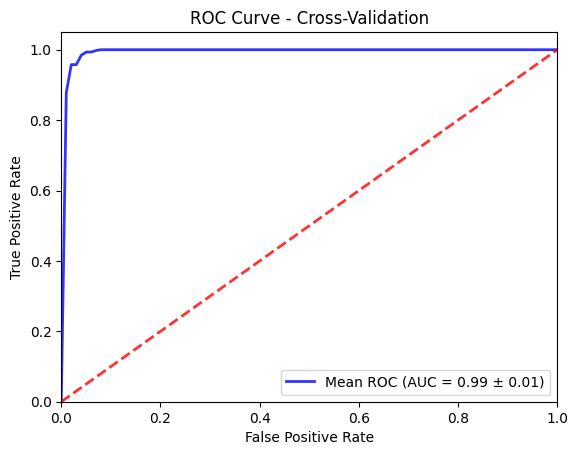

In [44]:
# Curva ROC

# Initialize StratifiedKFold with 5 folds
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store true labels and predicted probabilities
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)  # Para interpolar la curva ROC
feature_importances = []

# Perform k-fold cross-validation
for train_index, val_index in kf.split(X, y):
    X_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Define hyperparameters
    params = {
        'objective': 'binary:logistic',
        'learning_rate': 0.02654800750269553,
        'max_depth': 6,
        'min_child_weight': 3,
        'subsample': 0.8924428271655346,
        'gamma': 0.06402860746492733,
        'colsample_bytree': 0.9139972717407273,
        'scale_pos_weight': 3.866445091522391,
        'nthread': 4,
        'seed': 42
    }

    # Train the model with early stopping
    clf = train_with_early_stopping(X_fold, y_fold, X_val_fold, y_val_fold, params, early_stopping_rounds=10)

    # Predict probabilities on the validation set
    y_valid_fold_proba = clf.predict_proba(X_val_fold)[:, 1]

    # Compute ROC curve and AUC for the current fold
    fpr, tpr, _ = roc_curve(y_val_fold, y_valid_fold_proba)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Store feature importance for the current fold
    feature_importances.append(clf.feature_importances_)

# Compute the mean ROC curve and AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot the ROC curve
plt.figure()
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2, alpha=.8)

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

# Add labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Cross-Validation')
plt.legend(loc="lower right")
plt.show()

In [45]:
# Matriz de confusion

from sklearn.metrics import confusion_matrix # Importamos la matriz

# Initialize lists to store true labels and predicted labels
all_y_true = []
all_y_pred = []

# Perform k-fold cross-validation
for train_index, val_index in kf.split(X, y):
    X_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Define hyperparameters
    params = {
        'objective': 'binary:logistic',
        'learning_rate': 0.02654800750269553,
        'max_depth': 6,
        'min_child_weight': 3,
        'subsample': 0.8924428271655346,
        'gamma': 0.06402860746492733,
        'colsample_bytree': 0.9139972717407273,
        'scale_pos_weight': 3.866445091522391,
        'nthread': 4,
        'seed': 42
    }

    # Train the model with early stopping
    clf = train_with_early_stopping(X_fold, y_fold, X_val_fold, y_val_fold, params, early_stopping_rounds=10)

    # Predict classes on the validation set
    y_valid_fold_pred = clf.predict(X_val_fold)

    # Store the true labels and predicted labels
    all_y_true.extend(y_val_fold)
    all_y_pred.extend(y_valid_fold_pred)

# Convert lists to numpy arrays for metrics computation
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Compute the F1 score from the combined predictions
f1 = f1_score(all_y_true, all_y_pred)
print(f"F1 Score (averaged over all folds): {f1:.4f}")

Confusion Matrix:
[[1348  473]
 [   0 1821]]
F1 Score (averaged over all folds): 0.8851
